In [1]:
import numpy as np
import pandas as pd
import cv2
import os,sys
import glob
import shutil
import imutils
from matplotlib import pyplot as plt 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Input, MaxPooling2D, Activation, BatchNormalization, Concatenate, Dropout, Add, LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [34]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
pip install split-folders

#Multi-class Classification

In [4]:
count =0
#pre_list = glob.glob('/content/gdrive/My Drive/*')
!unzip '/content/gdrive/My Drive/slipfall_cropped_people_data.zip'

Archive:  /content/gdrive/My Drive/slipfall_cropped_people_data.zip
   creating: slipfall_cropped_people_data/
   creating: slipfall_cropped_people_data/running/
  inflating: slipfall_cropped_people_data/running/001066.jpg  
  inflating: slipfall_cropped_people_data/running/001933.jpg  
  inflating: slipfall_cropped_people_data/running/002624.jpg  
  inflating: slipfall_cropped_people_data/running/000145.jpg  
  inflating: slipfall_cropped_people_data/running/002791.jpg  
  inflating: slipfall_cropped_people_data/running/001071.jpg  
  inflating: slipfall_cropped_people_data/running/002569.jpg  
  inflating: slipfall_cropped_people_data/running/001100.jpg  
  inflating: slipfall_cropped_people_data/running/002839.jpg  
  inflating: slipfall_cropped_people_data/running/000009.jpg  
  inflating: slipfall_cropped_people_data/running/000631.jpg  
  inflating: slipfall_cropped_people_data/running/001507.jpg  
  inflating: slipfall_cropped_people_data/running/002543.jpg  
  inflating: slipfa

In [5]:
os.chdir('/content/slipfall_cropped_people_data')

import splitfolders
splitfolders.ratio("/content/slipfall_cropped_people_data", output="Split_data", ratio=(.7,.2,.1), seed = 42, group_prefix=None) # default values


Copying files: 3016 files [00:00, 7731.88 files/s]


In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory='/content/slipfall_cropped_people_data/Split_data/train', target_size=(224,224), shuffle = False,
                         class_mode='sparse')

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory='/content/slipfall_cropped_people_data/Split_data/val', target_size=(224,224), shuffle = False, 
                         class_mode='sparse')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory='/content/slipfall_cropped_people_data/Split_data/test', target_size=(224,224), shuffle = False, 
                         class_mode='sparse', batch_size = 1)

Found 2107 images belonging to 9 classes.
Found 599 images belonging to 9 classes.
Found 310 images belonging to 9 classes.


In [7]:
train_batches.num_classes
valid_batches.num_classes
test_batches.num_classes

9

In [8]:
Image_size = (224,224,3)

#loading the model
resnet = ResNet50(input_shape = Image_size , weights = 'imagenet', include_top = False)
        
#to prevent training existing weights
for layer in resnet.layers:
        layer.trainable = False

#build the model
x = resnet.input
y = resnet.output # a vector with a size of 2 for each image (2 probabilities)
y = Flatten(name = 'flatten')(y)
#normaliza the input to the neural network to speed up training
y = BatchNormalization()(y)
y = Dense(32, name = 'FC1')(y)
y = LeakyReLU()(y)
y = Dropout(0.2)(y)
#y = Dense(64, activation='relu', name = 'FC2')(y)
#y = Dropout(0.5)(y)
y = Dense(train_batches.num_classes, activation = 'softmax', name = 'prediction')(y)
model = Model(inputs = x, outputs = y)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#save results to a csv
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model_multi.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')



94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#train
hist = model.fit_generator(train_batches,validation_data = valid_batches , epochs=20, callbacks = [checkpoint],verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
66/66 [==============================] - 486s 7s/step - loss: 13.6786 - accuracy: 0.2036 - val_loss: 15.2478 - val_accuracy: 0.2254

Epoch 00001: val_accuracy improved from -inf to 0.22538, saving model to model_multi.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
66/66 [==============================] - 434s 7s/step - loss: 18.2465 - accuracy: 0.3251 - val_loss: 9.0056 - val_accuracy: 0.4124

Epoch 00002: val_accuracy improved from 0.22538 to 0.41235, saving model to model_multi.h5
Epoch 3/20
 4/66 [>.............................] - ETA: 5:19 - loss: 15.0506 - accuracy: 0.3984

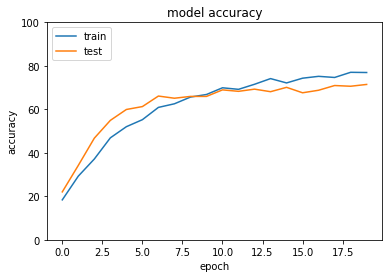

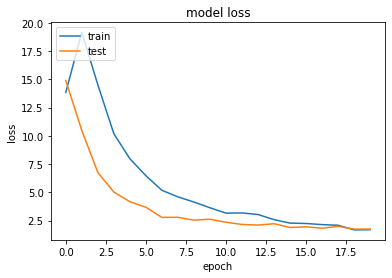

In [10]:
#plot results
t_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
t_acc = [i * 100 for i in t_acc]
val_acc = [i * 100 for i in val_acc]
plt.plot(t_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0,100)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_batches, workers = 0)

310/310 [==============================] - 5s 14ms/step - loss: 2.0260 - accuracy: 0.6806


In [12]:
yhat = model.predict(
    test_batches, steps=None, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=0
)

### N.B. The data is very unbalanced and hard to predict
#### get the evaluation metrics 

[2 8 0 8 0 0 0 0 0 0 0 2 0 2 0 0 7 0 2 0 0 2 0 7 0 2 0 0 0 0 0 0 2 7 0 0 0
 0 0 1 1 1 1 1 1 7 7 1 1 8 2 7 4 1 7 1 7 7 1 1 1 7 7 1 7 1 1 1 1 1 1 1 1 1
 1 1 8 8 1 1 8 6 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 3 1 8 8 1 1 2 8 2 2 7
 8 1 7 8 8 7 2 7 2 8 0 2 7 1 8 7 2 7 7 8 8 1 8 6 7 3 2 8 1 8 7 8 4 7 4 4 1
 1 4 1 2 4 4 4 7 4 4 2 2 5 7 2 6 6 6 6 6 7 6 6 7 7 8 7 7 8 7 7 7 7 7 7 7 7
 7 8 7 7 7 7 7 0 7 7 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 8 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 8 7 7 7 7 7 7 7 7 7 0 7 7 8 7 7 7 7 7 7 7 7 7 7 8 7
 7 7 7 7 0 7 8 8 8 7 8 8 8 8 8 8 8 0 8 8 8 7 8 8 8 8 7 0 8 2 3 8 8 8 7 8 8
 7 8 2 8 8 8 8 8 8 8 8 0 8 8]
Precision:  67.36420114110754
Recall:  55.49191191473775
Accuracy:  68.06451612903226
F1:  57.460746007513755


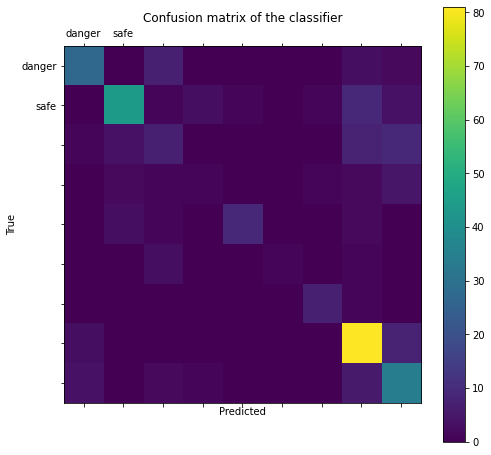

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score

#print(yhat)
y_pred = np.argmax(yhat, axis=1)
print(y_pred)
true_classes = test_batches.classes[test_batches.index_array]
#print(true_classes) # 0,1,2..etc
# class_labels = list(val_data.class_indices.keys())
# #print(classe_labels) # bending, falling,...etc
cm = confusion_matrix(true_classes, y_pred)



ps = precision_score(true_classes, y_pred, average = 'macro')
print('Precision: ',ps*100)
recall = recall_score(true_classes, y_pred,average = 'macro')
print('Recall: ',recall*100)
acc = accuracy_score(true_classes, y_pred)
print('Accuracy: ', acc*100)
f1 = f1_score(true_classes, y_pred,average = 'macro')
print('F1: ',f1*100)



fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(['']+['danger', 'safe'])
ax.set_yticklabels(['']+['danger', 'safe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Change the way of distributing the data + add the newly annotated images to increase the data size
### Train binary classifier instead

#Binary Classification

In [40]:
count =0
pre_list = glob.glob('/content/gdrive/My Drive/*')
os.chdir('/content/gdrive/My Drive/')
#print(pre_list)
!unzip '/content/gdrive/My Drive/slip_fall_binaryClass.zip'

Streaming output truncated to the last 5000 lines.
  inflating: slip_fall_binaryClass/safe/000612_1.jpg  
  inflating: __MACOSX/slip_fall_binaryClass/safe/._000612_1.jpg  
  inflating: slip_fall_binaryClass/safe/000377_9.jpg  
  inflating: __MACOSX/slip_fall_binaryClass/safe/._000377_9.jpg  
  inflating: slip_fall_binaryClass/safe/000939_1.jpg  
  inflating: __MACOSX/slip_fall_binaryClass/safe/._000939_1.jpg  
  inflating: slip_fall_binaryClass/safe/002495_9.jpg  
  inflating: __MACOSX/slip_fall_binaryClass/safe/._002495_9.jpg  
  inflating: slip_fall_binaryClass/safe/001793_1.jpg  
  inflating: __MACOSX/slip_fall_binaryClass/safe/._001793_1.jpg  
  inflating: slip_fall_binaryClass/safe/002975_6.jpg  
  inflating: __MACOSX/slip_fall_binaryClass/safe/._002975_6.jpg  
  inflating: slip_fall_binaryClass/safe/001949_9.jpg  
  inflating: __MACOSX/slip_fall_binaryClass/safe/._001949_9.jpg  
  inflating: slip_fall_binaryClass/safe/002953_5.jpg  
  inflating: __MACOSX/slip_fall_binaryClass/saf

In [41]:
os.chdir('/content/gdrive/MyDrive/slip_fall_binaryClass')

import splitfolders
splitfolders.ratio("/content/gdrive/MyDrive/slip_fall_binaryClass", output="Split_data", ratio=(.7,.2,.1), seed = 42, group_prefix=None) # default values


Copying files: 4127 files [00:55, 74.22 files/s]


In [44]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory='/content/gdrive/MyDrive/slip_fall_binaryClass/Split_data/train', target_size=(224,224), shuffle = False,
                         class_mode='sparse')

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory='/content/gdrive/MyDrive/slip_fall_binaryClass/Split_data/val', target_size=(224,224), shuffle = False, 
                         class_mode='sparse')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input) \
    .flow_from_directory(directory='/content/gdrive/MyDrive/slip_fall_binaryClass/Split_data/test', target_size=(224,224), shuffle = False, 
                         class_mode='sparse', batch_size = 1)

Found 2888 images belonging to 2 classes.
Found 825 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


In [45]:
X,Y = test_batches.next()
X.shape

(1, 224, 224, 3)

In [46]:
train_batches.num_classes
valid_batches.num_classes
test_batches.num_classes

2

In [47]:
Image_size = (224,224,3)

#loading the model
resnet = ResNet50(input_shape = Image_size , weights = 'imagenet', include_top = False)
        
#to prevent training existing weights
for layer in resnet.layers:
        layer.trainable = False

#build the model
x = resnet.input
y = resnet.output # a vector with a size of 2 for each image (2 probabilities)
y = Flatten(name = 'flatten')(y)
#normaliza the input to the neural network to speed up training
y = BatchNormalization()(y)
y = Dense(32, name = 'FC1')(y)
y = LeakyReLU()(y)
y = Dropout(0.2)(y)
#y = Dense(64, activation='relu', name = 'FC2')(y)
#y = Dropout(0.5)(y)
y = Dense(2, activation = 'softmax', name = 'prediction')(y)
model = Model(inputs = x, outputs = y)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#save results to a csv
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')



In [48]:
#train
hist = model.fit_generator(train_batches,validation_data = valid_batches , epochs=20, callbacks = [checkpoint],verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
91/91 [==============================] - 21s 195ms/step - loss: 4.3681 - accuracy: 0.6229 - val_loss: 5.9772 - val_accuracy: 0.5891

Epoch 00001: val_accuracy improved from -inf to 0.58909, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
91/91 [==============================] - 16s 176ms/step - loss: 5.2288 - accuracy: 0.6517 - val_loss: 2.8392 - val_accuracy: 0.6545

Epoch 00002: val_accuracy improved from 0.58909 to 0.65455, saving model to model.h5
Epoch 3/20
91/91 [==============================] - 16s 172ms/step - loss: 2.0316 - accuracy: 0.7652 - val_loss: 1.3468 - val_accuracy: 0.7139

Epoch 00003: val_accuracy improved from 0.65455 to 0.71394, saving model to model.h5
Epoch 4/20
91/91 [==============================] - 16s 172ms/step - loss: 0.7431 - accuracy: 0.8584 - val_loss: 0.8537 - val_accuracy: 0.7733

Epoch 00004: val_accuracy improved from 0.71394 to 0.77333, saving model to model.h5
Epoch 5/20
91/91 [==============================] - 16s 171ms/step - loss: 0.4012 - accuracy: 0.8996 - val_loss: 0.6634 - val_accuracy: 0.7782

Epoch 00005: val_accuracy improved from 0.77333 to 0.77818, saving model to model.h5
Epoch 6/20
91/91 [==============================] - 16s 178ms/step - loss: 0.2591 - 

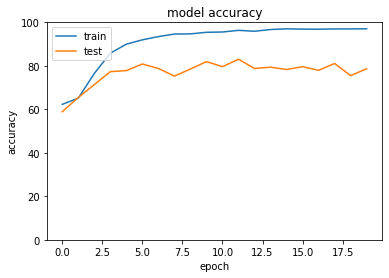

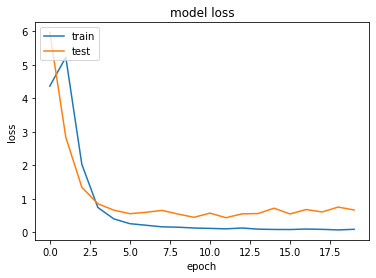

In [49]:
#plot results
t_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
t_acc = [i * 100 for i in t_acc]
val_acc = [i * 100 for i in val_acc]
plt.plot(t_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0,100)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
test_loss, test_acc = model.evaluate(test_batches, workers = 0)

414/414 [==============================] - 6s 16ms/step - loss: 0.6240 - accuracy: 0.7850


In [51]:
yhat = model.predict(
    test_batches, steps=None, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=0
)

In [52]:
test_batches.class_indices

{'danger': 0, 'safe': 1}

[1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0
 1 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1
 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1]
Precision:  74.21875
Recall:  89.2018779342723
Accuracy:  78.50241545893721
F1:  81.02345415778251


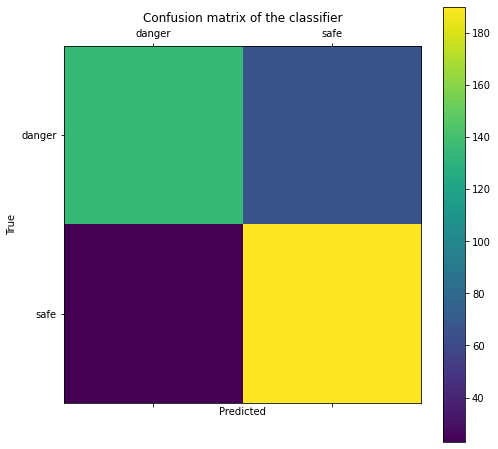

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score

#print(yhat)
y_pred = np.argmax(yhat, axis=1)
print(y_pred)
true_classes = test_batches.classes[test_batches.index_array]
#print(true_classes) # 0,1,2..etc
# class_labels = list(val_data.class_indices.keys())
# #print(classe_labels) # bending, falling,...etc
cm = confusion_matrix(true_classes, y_pred)



ps = precision_score(true_classes, y_pred)
print('Precision: ',ps*100)
recall = recall_score(true_classes, y_pred)
print('Recall: ',recall*100)
acc = accuracy_score(true_classes, y_pred)
print('Accuracy: ', acc*100)
f1 = f1_score(true_classes, y_pred)
print('F1: ',f1*100)



fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(['']+['danger', 'safe'])
ax.set_yticklabels(['']+['danger', 'safe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### The results improved a lot after changing data-splitting strategy and increasing its size

# Try predict on a video
##### The following script was written originally by Joseph Asaker

In [54]:
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2687, done.
remote: Counting objects: 100% (2687/2687), done.
remote: Compressing objects: 100% (2234/2234), done.
remote: Total 2687 (delta 681), reused 1240 (delta 420), pack-reused 0
Receiving objects: 100% (2687/2687), 32.66 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (681/681), done.
Checking out files: 100% (2483/2483), done.


In [55]:

# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/gdrive/My Drive/slip_fall_binaryClass/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1652954 sha256=960cbf24183ceed83bef49b600bebc572f7927c4565fcd37551214692394cafb
  Stored in directory: /tmp/pip-ephem-wheel-cache-cwlfhmd5/wheels/d9/6f/b4/978c23360894dc8a4e60029c6e3758509b36f9d8cb412a9812
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=aedf1f2b935d671460346fdb20b758f3d1d0a2b86720f5d1e201d264fb77081a
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=9191a1c085ce56a2dd7a40257a9a75c488d6b8a67b27ffed4ee49300543f9e05
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=d0ca1669c3de4a

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.30.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [56]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [57]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [58]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
!tar -xvf faster_rcnn_resnet101_coco_2018_01_28.tar.gz

--2021-06-10 17:31:33--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.141.128, 2607:f8b0:4023:c0b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593445323 (566M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet101_coco_2018_01_28.tar.gz’

faster_rcnn_resnet1 100%[===================>] 565.95M  47.1MB/s    in 9.6s    

2021-06-10 17:31:43 (59.2 MB/s) - ‘faster_rcnn_resnet101_coco_2018_01_28.tar.gz’ saved [593445323/593445323]

faster_rcnn_resnet101_coco_2018_01_28/
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet101_coco_2018_01_28/checkpoint
faster_rcnn_resnet101_coco_2018_01_28/pipeline.config
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.meta
faster_rcnn_

In [59]:
PATH_TO_CKPT = "faster_rcnn_resnet101_coco_2018_01_28" + '/frozen_inference_graph.pb'

In [60]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [61]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()  
  with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [62]:
# Label names for class numbers
pose_rep={0: 'danger',
 1: 'safe'}

In [63]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

def pose_infer(image):
  model = define_model()
  #image = load_img(image,target_size=(224, 224))
  image = img_to_array(image)
  # reshape data for the model
  image = np.resize(image, (1,224,224,3))
  # prepare the image for the Resnet model
  image = preprocess_input(image)
  yhat = model.predict(image)
  #yhat = yhat.argmax()
  return yhat


In [64]:
import time
from scipy.ndimage.filters import gaussian_filter
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow


In [65]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

In [69]:
def inference_on_video(filename, output_seconds=3600):
    output_filename = f"output_of_{filename}"
    codec = cv2.VideoWriter_fourcc(*'XVID')
    #codec = cv2.VideoWriter_fourcc( *"MP4V" )
    cap = cv2.VideoCapture(filename)
    framerate = round(cap.get(5),2)
    w = int(cap.get(3))
    h = int(cap.get(4))
    resolution = (w, h)

    VideoFileOutput = cv2.VideoWriter('/content/gdrive/MyDrive/output.mp4', codec, framerate, resolution)  

    print('Framerate:', framerate)

    frames = 0

    with detection_graph.as_default():
        with tf.compat.v1.Session() as sess:
            model = load_model('/content/gdrive/MyDrive/slip_fall_binaryClass/model.h5')
            while cap.isOpened() and frames <= framerate * output_seconds:

                start = time.time()
                ret, image_np = cap.read()
                if not ret:
                  break

                rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

                # Actual detection.
                ops = tf.compat.v1.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                    'num_detections', 'detection_boxes', 'detection_scores',
                    'detection_classes', 'detection_masks'
                ]:
                  tensor_name = key + ':0'
                  if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(
                        tensor_name)
                if 'detection_masks' in tensor_dict:
                  # The following processing is only for single image
                  detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                  detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                  # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                  real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                  detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                  detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                      detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
                  detection_masks_reframed = tf.cast(
                      tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                  # Follow the convention by adding back the batch dimension
                  tensor_dict['detection_masks'] = tf.expand_dims(
                      detection_masks_reframed, 0)
                image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')

                # Run inference
                output_dict = sess.run(tensor_dict,
                                      feed_dict={image_tensor: np.expand_dims(image_np, 0)})

                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict['num_detections'] = int(output_dict['num_detections'][0])
                output_dict['detection_classes'] = output_dict[
                    'detection_classes'][0].astype(np.uint8)
                output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                output_dict['detection_scores'] = output_dict['detection_scores'][0]
                if 'detection_masks' in output_dict:
                  output_dict['detection_masks'] = output_dict['detection_masks'][0]


                # Visualization of the results of a detection.
                # Cropping each picture of humans detected.
                rects = []
                for i, class_id in enumerate(output_dict['detection_classes']):
                  if class_id == 1 and output_dict['detection_scores'][i] > 0.6: # 60% Person
                    y1, x1, y2, x2 = output_dict['detection_boxes'][i]
                    x1 *= image_np.shape[1]
                    x2 *= image_np.shape[1]
                    y1 *= image_np.shape[0]
                    y2 *= image_np.shape[0]
                    rects.append([int(x1), int(y1), int(x2), int(y2)])
                    person_cropped = image_np[int(y1):int(y2), int(x1):int(x2),:]
                    person_cropped = array_to_img(person_cropped)
                    image = img_to_array(person_cropped)
                    # reshape data for the model
                    image = np.resize(image, (1,224,224,3))
                    # prepare the image for the Resnet model
                    image = preprocess_input(image)
                    pose = model.predict(image, workers = 0)

                    x1 = int(x1)
                    x2 = int(x2)
                    y1 = int(y1)
                    y2 = int(y2)

                    ### INSERT YOUR LOGIC HERE FOR EACH CROPPED PERSON ###
                    #pose = pose_infer(person_cropped) #gets pose number from model prediction
                    name=pose_rep[np.argmax(pose)]
                    cv2.rectangle(image_np,(x1,y1),(x2,y2),(0,255,0), 2)
                    image_np=cv2.putText(image_np,name,(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
                    image_np=cv2.putText(image_np,str(np.max(pose)),(x1,y1+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    #cv2_imshow(image_np)

                VideoFileOutput.write(image_np)
                
                if frames % framerate == 0:
                  print(f'Frame {frames} ({frames/framerate :.4} seconds) Done in: {round(time.time() - start, 2)} s')
                  
                frames += 1

    cap.release()
    VideoFileOutput.release()
    print('done')

In [70]:
inference_on_video('/content/gdrive/MyDrive/bald-slip.mp4')

Framerate: 30.0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Frame 0 (0.0 seconds) Done in: 6.25 s
Frame 30 (1.0 seconds) Done in: 0.17 s
Frame 60 (2.0 seconds) Done in: 0.2 s
Frame 90 (3.0 seconds) Done in: 0.16 s
Frame 120 (4.0 seconds) Done in: 0.18 s
Frame 150 (5.0 seconds) Done in: 0.18 s
done
